In [70]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os
from pmdarima import auto_arima
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pd.plotting.register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [71]:
sql = """
select * from
`ffn-dw-bigquery-prd.Mani.Daily_Leadtime_adtime_aggregated_v1`
order by min10_window_g
"""
project_id = 'ffn-dw-bigquery-prd'
daily = pd.read_gbq(sql, project_id=project_id, dialect='standard')

Downloading: 100%|███████████████████████████████████████████████████████████| 82836/82836 [00:14<00:00, 5815.16rows/s]


In [72]:
daily.to_csv("daily.csv")

In [147]:
daily.head()
# daily.describe()

,min10_window_g,ts,year,month,weekday,isoweek,week,week_of,Day,hour_window,min_window,ad_aired_agg_10min,aired_agg_10min,netcost_10min,HHImp_agg_10min,CPM1000_agg_10min,lead_agg_10min
0,2018-11-30 16:00:00+00:00,2018-11-30 16:00:00,2018,11,5,48,47,2018-11-26,30,16,0,0,0,0.0,0,0.0,0
1,2018-11-30 16:10:00+00:00,2018-11-30 16:10:00,2018,11,5,48,47,2018-11-26,30,16,10,0,0,0.0,0,0.0,0
2,2018-11-30 16:20:00+00:00,2018-11-30 16:20:00,2018,11,5,48,47,2018-11-26,30,16,20,0,0,0.0,0,0.0,0
3,2018-11-30 16:30:00+00:00,2018-11-30 16:30:00,2018,11,5,48,47,2018-11-26,30,16,30,0,0,0.0,0,0.0,0
4,2018-11-30 16:40:00+00:00,2018-11-30 16:40:00,2018,11,5,48,47,2018-11-26,30,16,40,0,0,0.0,0,0.0,0


In [73]:
##Drop the lead_date column
df = daily.copy().drop(['min10_window_g'],axis=1)
# df.head()

In [74]:
df_s = df.set_index('ts')
# df_s.head()

In [75]:
df_s['weekend'] = np.where(df_s['weekday']>5, 1, 0)

In [76]:
df1 = df_s[62826:70884].copy()
df1.describe()

,year,month,weekday,isoweek,week,Day,hour_window,min_window,ad_aired_agg_10min,aired_agg_10min,netcost_10min,HHImp_agg_10min,CPM1000_agg_10min,lead_agg_10min,weekend
count,8058.0,8058.000000,8058.000000,8058.000000,8058.000000,8058.000000,8058.000000,8058.000000,8058.000000,8058.000000,8058.0,8058.0,8058.0,8058.000000,8058.000000
mean,2020.0,2.731943,3.997766,10.500372,9.642591,16.095309,11.507074,25.000000,0.000993,0.000993,0.0,0.0,0.0,1.665053,0.285182
std,0.0,0.612334,1.999192,2.292242,2.318841,8.707048,6.920335,17.079311,0.031495,0.031495,0.0,0.0,0.0,2.045012,0.451529
min,2020.0,2.000000,1.000000,7.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,2020.0,2.000000,2.000000,8.000000,8.000000,10.000000,6.000000,10.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,2020.0,3.000000,4.000000,11.000000,10.000000,17.000000,12.000000,25.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000
75%,2020.0,3.000000,6.000000,13.000000,12.000000,24.000000,18.000000,40.000000,0.000000,0.000000,0.0,0.0,0.0,3.000000,1.000000
max,2020.0,4.000000,7.000000,14.000000,14.000000,31.000000,23.000000,50.000000,1.000000,1.000000,0.0,0.0,0.0,27.000000,1.000000


In [77]:
# df2 = df1[(df1['aired_agg_10min']==0) & (df1['lead_agg_10min']<=25)]

In [78]:
# df2.describe()

,year,month,weekday,isoweek,week,Day,hour_window,min_window,ad_aired_agg_10min,aired_agg_10min,netcost_10min,HHImp_agg_10min,CPM1000_agg_10min,lead_agg_10min,weekend
count,8049.0,8049.000000,8049.000000,8049.000000,8049.000000,8049.000000,8049.000000,8049.000000,8049.0,8049.0,8049.0,8049.0,8049.0,8049.000000,8049.000000
mean,2020.0,2.732016,4.001118,10.499938,9.642316,16.093304,11.511741,25.026711,0.0,0.0,0.0,0.0,0.0,1.660827,0.285501
std,0.0,0.612470,1.997793,2.292054,2.318705,8.706323,6.922723,17.069831,0.0,0.0,0.0,0.0,0.0,2.025130,0.451681
min,2020.0,2.000000,1.000000,7.000000,6.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,2020.0,2.000000,2.000000,8.000000,8.000000,10.000000,6.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,2020.0,3.000000,4.000000,11.000000,10.000000,17.000000,12.000000,30.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
75%,2020.0,3.000000,6.000000,13.000000,12.000000,24.000000,18.000000,40.000000,0.0,0.0,0.0,0.0,0.0,3.000000,1.000000
max,2020.0,4.000000,7.000000,14.000000,14.000000,31.000000,23.000000,50.000000,0.0,0.0,0.0,0.0,0.0,24.000000,1.000000


In [160]:
#create the training and testing data sets
np.random.seed(123)
mask = np.random.rand(len(df1)) < 0.8
df_train = df1[mask]
df_test = df1[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))
# df_test.head()
# Training data set length=7272
# Testing data set length=777

Training data set length=6473
Testing data set length=1585


In [195]:
#Setup the regression expression in patsy notation. We are telling patsy that 'lead_agg_10min' is our dependent variable and it depends on the regression variables: month + weekday + week + hour_window + min_window
expr = """lead_agg_10min ~  month + Day+ weekday + week + weekend+hour_window + min_window"""

In [196]:
#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [163]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [164]:
#print out the training summary
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         lead_agg_10min   No. Observations:                 6473
Model:                            GLM   Df Residuals:                     6465
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12389.
Date:                Sun, 19 Jul 2020   Deviance:                       13829.
Time:                        08:40:18   Pearson chi2:                 1.42e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0284      0.197      5.229      

##### Deviance:15576 and Pearson chi2:15800 df- 7271 the Chi-sq value at p=0.05 is 1074.679 which is smaller than the Deviance and Pearson-Chi2 for the model hence Poisson Model is not a good fit for the model. 
https://www.medcalc.org/manual/chi-square-table.php

##### We check for the alternatives
 ######  ->> Binomial Regression model
 ######   ->> Zero Inflated Poisson model (ZIP model)¶
 ######   ->> Generalized Poisson Regression Model (GP1 and GP2)

In [165]:
#print out the fitted rate vector
poisson_training_results.mu

array([2.22848657, 2.24098209, 2.25354769, ..., 0.86100444, 0.87068712,
       0.87556922])

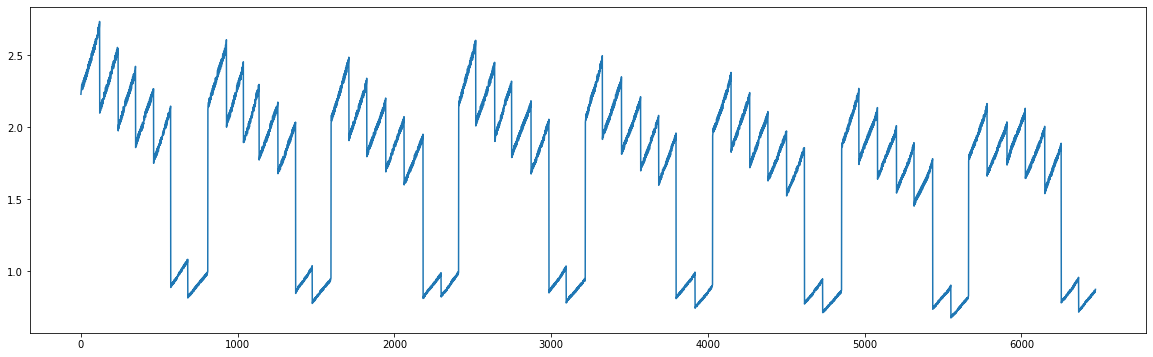

In [181]:
fig = plt.figure(figsize = (20,6))
plt.plot(poisson_training_results.mu)

In [197]:
#Add the λ vector as a new column called 'Org_LAMBDA' to the Data Frame of the training data set
df_train['Lead_LAMBDA'] = poisson_training_results.mu

In [183]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/627/1*i_xrzg4Kfo7WKQ0a0wa5Fw.png")

![title](NB.jpg)

In [198]:
#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['lead_agg_10min'] - x['Lead_LAMBDA'])**2 - x['lead_agg_10min']) / x['Lead_LAMBDA'], axis=1)

In [199]:
#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ Lead_LAMBDA - 1"""

In [200]:
#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [201]:
#Print the regression params
print(aux_olsr_results.params)

Lead_LAMBDA    0.727808
dtype: float64


In [202]:
aux_olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            AUX_OLS_DEP   R-squared (uncentered):                   0.039
Model:                            OLS   Adj. R-squared (uncentered):              0.038
Method:                 Least Squares   F-statistic:                              259.6
Date:                Sun, 19 Jul 2020   Prob (F-statistic):                    2.70e-57
Time:                        09:51:03   Log-Likelihood:                         -21210.
No. Observations:                6473   AIC:                                  4.242e+04
Df Residuals:                    6472   BIC:                                  4.243e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Lead_LAMBDA     0.7278      0.045     16.112      0.000       0.639       0.816
==============================================================================
Omnibus:                    16209.289   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        315968236.528
Skew:                          27.117   Prob(JB):                         0.00
Kurtosis:                    1084.007   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [204]:
#Set up the X and y matrices for the training and testing data sets
y_train1, X_train1 = dmatrices(expr, df_train, return_type='dataframe')
y_test1, X_test1 = dmatrices(expr, df_test, return_type='dataframe')

In [205]:
#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [206]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         lead_agg_10min   No. Observations:                 6473
Model:                            GLM   Df Residuals:                     6465
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11161.
Date:                Sun, 19 Jul 2020   Deviance:                       7082.2
Time:                        09:53:32   Pearson chi2:                 6.35e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9595      0.263      3.647      0.000       0.444       1.475
month           0.0558      0.273      0.205      0.838      -0.478       0.590
Day            -0.0019      0.009     -0.204      0.839      -0.020       0.016
weekday        -0.0574      0.013     -4.324      0.000      -0.083      -0.031
week           -0.0391      0.064     -0.606      0.544      -0.165       0.087
weekend        -0.6188      0.059    -10.473      0.000      -0.735      -0.503
hour_window     0.0113      0.002      5.362      0.000       0.007       0.015
min_window      0.0008      0.001      0.914      0.361      -0.001       0.002
===============================================================================
"""

In [207]:
#Setup the regression expression in patsy notation. We are telling patsy that 'lead_agg_10min' is our dependent variable and it depends on the regression variables: month + weekday + week + hour_window + min_window
expr2 = """lead_agg_10min ~  weekday+ weekend+hour_window"""

In [209]:
#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr2, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr2, df_test, return_type='dataframe')
X_train.head()

,Intercept,weekday,weekend,hour_window
ts,,,,
2020-02-10 00:00:00,1.0,1.0,0.0,0.0
2020-02-10 00:10:00,1.0,1.0,0.0,0.0
2020-02-10 00:20:00,1.0,1.0,0.0,0.0
2020-02-10 00:30:00,1.0,1.0,0.0,0.0
2020-02-10 00:40:00,1.0,1.0,0.0,0.0


In [210]:
#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [211]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         lead_agg_10min   No. Observations:                 6473
Model:                            GLM   Df Residuals:                     6469
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11172.
Date:                Sun, 19 Jul 2020   Deviance:                       7105.1
Time:                        09:54:56   Pearson chi2:                 6.32e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7280      0.045     16.324      0.000       0.641       0.815
weekday        -0.0567      0.011     -4.975      0.000      -0.079      -0.034
weekend        -0.6312      0.054    -11.665      0.000      -0.737      -0.525
hour_window     0.0112      0.002      5.325      0.000       0.007       0.015
===============================================================================
"""

In [218]:
dfh = df_s[70884:82836].copy()
dfh1 = dfh[(dfh['lead_agg_10min']<=200)]
dfh1.head(), dfh1.tail()
y_hold, X_hold = dmatrices(expr2, dfh1, return_type='dataframe')
# y_hold.head(), X_hold.tail()

In [219]:
#make some predictions using our trained NB2 model
nb2_pred_train = nb2_training_results.get_prediction(X_train)
nb2_pred_test = nb2_training_results.get_prediction(X_test)
nb2_pred_hold = nb2_training_results.get_prediction(X_hold)

In [220]:
#assign predictions
predictions_summary_train = nb2_pred_train.summary_frame()
predictions_summary_test = nb2_pred_test.summary_frame()
predictions_summary_hold = nb2_pred_hold.summary_frame()

In [230]:
df_train_p = pd.merge(y_train, predictions_summary_train, left_index=True, right_index=True)
df_test_p = pd.merge(y_test,predictions_summary_test, left_index=True, right_index=True)
df_hold_p = pd.merge(y_hold, predictions_summary_hold, left_index=True, right_index=True)

In [238]:
df_final_p =pd.concat([df_train_p, df_test_p, df_hold_p])
df_final_p.info()
df_final_p.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20009 entries, 2020-02-10 00:00:00 to 2020-06-27 23:50:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lead_agg_10min  20009 non-null  float64
 1   mean            20009 non-null  float64
 2   mean_se         20009 non-null  float64
 3   mean_ci_lower   20009 non-null  float64
 4   mean_ci_upper   20009 non-null  float64
dtypes: float64(5)
memory usage: 937.9 KB


,lead_agg_10min,mean,mean_se,mean_ci_lower,mean_ci_upper
ts,,,,,
2020-02-10 00:00:00,0.0,1.956688,0.07208,1.820394,2.103186
2020-02-10 00:10:00,1.0,1.956688,0.07208,1.820394,2.103186
2020-02-10 00:20:00,0.0,1.956688,0.07208,1.820394,2.103186
2020-02-10 00:30:00,0.0,1.956688,0.07208,1.820394,2.103186
2020-02-10 00:40:00,0.0,1.956688,0.07208,1.820394,2.103186


In [244]:
from pandas.tseries.offsets import Week
ds = df_final_p.index.to_series()
df_final_p['MONTH'] = ds.dt.month
df_final_p['Date_m'] = ds.dt.date
# df_final_p['Day'] = ds.dt.day
# df_final_p['Week'] = ds.dt.week
# df_final_p['Year'] = ds.dt.year
df_final_p['Hour'] = ds.dt.hour
df_final_p['Minute'] = ds.dt.minute
# df_final_p['Name_of_day']=ds.dt.day_name()
df_final_p['Week_of'] = (ds.where(ds.dt.weekday == 0, ds - Week(weekday=0))).dt.date
df_final_p.sort_index()
df_final_p.tail()

,lead_agg_10min,mean,mean_se,mean_ci_lower,mean_ci_upper,MONTH,Date_m,Hour,Minute,Week_of
ts,,,,,,,,,,
2020-06-27 23:10:00,0.0,1.01447,0.040726,0.937708,1.097515,6,2020-06-27,23,10,2020-06-22
2020-06-27 23:20:00,0.0,1.01447,0.040726,0.937708,1.097515,6,2020-06-27,23,20,2020-06-22
2020-06-27 23:30:00,0.0,1.01447,0.040726,0.937708,1.097515,6,2020-06-27,23,30,2020-06-22
2020-06-27 23:40:00,0.0,1.01447,0.040726,0.937708,1.097515,6,2020-06-27,23,40,2020-06-22
2020-06-27 23:50:00,0.0,1.01447,0.040726,0.937708,1.097515,6,2020-06-27,23,50,2020-06-22


In [246]:
df_agg_day = df_final_p.groupby(['Week_of', 'Date_m']).agg({'lead_agg_10min': 'sum', 'mean': 'sum'})
# df_agg_day.head(25)
df_agg_day.to_csv("nb2_daily_pred.csv")

In [247]:
df_week_day = df_final_p.groupby(['Week_of']).agg({'lead_agg_10min': 'sum', 'mean': 'sum'})
# df_agg_day.head(25)
df_week_day.to_csv("nb2_weekly_pred.csv")

##### Redundant code for export

In [221]:
# predicted_train=predictions_summary_train['mean']
# actual_train = y_train['lead_agg_10min']

# predicted_test=predictions_summary_test['mean']
# actual_test = y_train['lead_agg_10min']

# predicted_hold=predictions_summary_hold['mean']
# actual_hold = y_hold['lead_agg_10min']

In [222]:
week_of = df_train['week_of']
Date = df_train.index.to_series()
# Date.head()

In [223]:
week_of1 = df_test['week_of']
Date1 = df_test.index.to_series()

In [224]:
week_of2 = dfh1['week_of']
Date2 = dfh1.index.to_series()

In [225]:
df_train_pred = pd.DataFrame({'Date': Date, 'week_of': week_of, 'Actual_volume': actual_train, 'Predicted':predicted_train})
df_test_pred = pd.DataFrame({'Date': Date1, 'week_of': week_of1, 'Actual_volume': actual_test, 'Predicted':predicted_test})
df_hold_pred = pd.DataFrame({'Date': Date2, 'week_of': week_of2, 'Actual_volume': actual_hold, 'Predicted':predicted_hold})

In [248]:
# df_final =pd.concat([df_train_pred, df_test_pred, df_hold_pred])
# df_final.head()

In [249]:
# ds = df_final.index.to_series()
# df_final['MONTH'] = ds.dt.month
# df_final['Date_m'] = ds.dt.date
# df_final['Day'] = ds.dt.day
# df_final['Week'] = ds.dt.week
# df_final['Year'] = ds.dt.year
# df_final['Hour'] = ds.dt.hour
# df_final['Minute'] = ds.dt.minute
# df_final.sort_index()
# df_final.head()

In [250]:
df_agg_day = df_final.groupby(['week_of', 'Date_m']).agg({'Actual_volume': 'sum', 'Predicted': 'sum'})
# df_agg_day.head(25)
# df_agg_day.to_csv("nb_daily_predictions.csv")

In [251]:
# df_agg_week = df_final.groupby(['week_of']).agg({'Actual_volume': 'sum', 'Predicted': 'sum'})
# # df_agg_week.describe()
# df_agg_week.head(25)
# df_agg_week.to_csv("nb_weekly_predictions.csv")

In [252]:
# result = pd.merge(df_final, df_s[['aired_agg_10min']], left_index=True, right_index=True)
# result.tail(50)

In [253]:
# #plot the predicted counts versus the actual counts for the test data
# predicted_counts=predictions_summary_frame['mean']
# actual_counts = y_test['lead_agg_10min']
# fig = plt.figure(figsize = (20, 6))
# fig.suptitle('Predicted versus actual Daily Lead volume')
# predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
# actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
# plt.legend(handles=[predicted, actual])
# plt.show()